In [0]:
!pip install -q bigartm10

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import artm

In [5]:
from google.colab import drive
drive.mount('/content/drive/')
gDrivePath = "/content/drive/My Drive/M1P/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
with open(gDrivePath + '/data/wiki.bin', 'rb') as f:
    data_new = pickle.load(f)

In [37]:
data_new[2702897]

('Криволинейная трапеция\n\nКриволине́йная трапе́ция\xa0— плоская фигура, ограниченная графиком неотрицательной непрерывной функции formula_1, определенной на отрезке [a; b], осью абсцисс и прямыми formula_2 и formula_3.\n\nДля нахождения площади криволинейной трапеции пользуются интегралом.\n\nformula_4\n\nИли\n\nformula_5\n\nЭто значит, что площадь криволинейной трапеции можно найти по сумме значений функции formula_1 взятые через бесконечно малые промежутки по оси Ох на отрезке от formula_7 до formula_8\n\nМожно сказать, что мы разбили криволинейную трапецию на бесконечное число прямоугольников, длина каждого из которых равна ординате функции formula_9 через бесконечно малые промежутки по оси Ох на отрезке от formula_7 до formula_8, а ширина\xa0— бесконечно малому значению х, нашли их площади произведением длины на ширину и сложили. Предел суммы их площадей равен площади криволинейной трапеции.\n',
 'криволинейный трапеция криволина йный трап ция плоский фигура ограниченный график н

In [0]:
with open(gDrivePath + '/data/full_wiki_meta.bin', 'rb') as f:
    meta = pickle.load(f)

In [10]:
meta['7306701']

{'title': 'Отбор признаков',
 'url': 'https://ru.wikipedia.org/wiki?curid=7306701'}

In [0]:
with open(gDrivePath + '/data/validation.bin', 'rb') as f:
    trees = pickle.load(f)

In [0]:
trees[0]

# В vowpal_wabbit формат

In [0]:
data = data_new.copy()

In [39]:
len(data)

61734

In [40]:
df = pd.DataFrame(data.items(), columns=['N', 'Text'])
df['N']

0         708071
1         761393
2        7474856
3          52789
4        6759811
          ...   
61729    7711954
61730    2584885
61731    5211102
61732    6649968
61733     374424
Name: N, Length: 61734, dtype: int64

In [0]:
vw = df['Text'].apply(lambda x: '|text ' + x[1])

In [20]:
#vw[0]

'|text глазомер глазома способность определять расстояние прибегать помощь какой-либо прибор устройство собственный глаз выработать хороший глазомер следовать постоянно упражняться определение расстояние частый измерять глаз помощь расчёт расстояние видимый предмет определять крутизна склон ширина скорость река знать длина рост толщина палец визировать видеть предмет фигура следующий расстояние зрение различно пользоваться таблица проверить приводить практика необходимый поправка'

In [0]:
with open(gDrivePath + '/data/wiki.txt', 'w') as fout:
    for line in vw:
        fout.write(line + '\n')

# Строим тематическую модель

In [0]:
#batch_vectorizer = artm.BatchVectorizer(data_path=gDrivePath + '/data/wiki.txt', data_format='vowpal_wabbit', collection_name='wiki', target_folder=gDrivePath + '/data/batches')

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path=gDrivePath + '/data/batches', data_format = 'batches')

In [0]:
dictionary = artm.Dictionary()

model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(7)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       cache_theta=True)

model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(7)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
                                     artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1)],
                       cache_theta=True)

In [0]:
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [0]:
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

In [24]:
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary

artm.Dictionary(name=436956e1-516e-479f-a45a-05ce5e1c3d95, num_entries=397876)

In [0]:
model_plsa.initialize(dictionary=dictionary)
model_artm.initialize(dictionary=dictionary)

In [0]:
model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

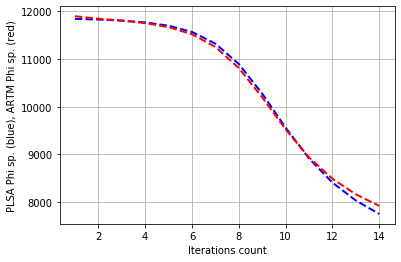

In [27]:
plt.plot(range(1, model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value[1:], 'b--',
         range(1, model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value[1:], 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

In [28]:
len(model_artm.score_tracker['TopicKernelScore'].tokens[0]['topic_5'])

46859

In [29]:
model_artm.score_tracker['SparsityPhiScore'].last_value

0.7715307474136353

In [30]:
model_artm.score_tracker['SparsityThetaScore'].last_value

0.009226219728589058

In [0]:
model_artm.save(gDrivePath + '/code/artm.bin')
model_plsa.save(gDrivePath + '/code/plsa.bin')

# Строим граф

τ , which defines the minimum overlap between two equivalent documents, and κ, which defines the maximum difference of their generality scores

In [0]:
N = 61734
t = 0.7
k = 0.005

In [0]:
# dictionary = artm.Dictionary()

# model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(114)],
#                        scores=[artm.PerplexityScore(name='PerplexityScore',
#                                                     dictionary=dictionary)],
#                        cache_theta=True)

# model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(114)],
#                        scores=[artm.PerplexityScore(name='PerplexityScore',
#                                                     dictionary=dictionary)],
#                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
#                                      artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1)],
#                        cache_theta=True)

In [0]:
# model_artm.load(gDrivePath + '/code/artm.bin')
# model_plsa.load(gDrivePath + '/code/plsa.bin')

In [68]:
#F = model_plsa.get_theta()
#F.to_csv(gDrivePath+'/data/plsa_theta.csv')
F = pd.read_csv(gDrivePath+'/data/plsa_theta.csv', index_col=0)
F.head()

,11000,11001,11002,11003,11004,11005,11006,11007,11008,11009,11010,11011,11012,11013,11014,11015,11016,11017,11018,11019,11020,11021,11022,11023,11024,11025,11026,11027,11028,11029,11030,11031,11032,11033,11034,11035,11036,11037,11038,11039,...,28960,28961,28962,28963,28964,28965,28966,28967,28968,28969,28970,28971,28972,28973,28974,28975,28976,28977,28978,28979,28980,28981,28982,28983,28984,28985,28986,28987,28988,28989,28990,28991,28992,28993,28994,28995,28996,28997,28998,28999
topic_0,0.208919,0.092349,0.067374,0.074725,0.167370,0.108043,0.233168,0.078818,0.042506,0.060388,0.084268,0.505673,0.093327,0.097881,0.115397,0.097115,0.140214,0.104773,0.086053,0.101996,0.043233,0.135809,0.033599,0.109583,0.218678,0.102687,0.099959,0.117527,0.338648,0.260260,0.024380,0.057154,0.149899,0.077100,0.083606,0.070882,0.105305,0.159121,0.169241,0.126785,...,0.108614,0.351455,0.056148,0.153082,0.078157,0.049496,0.124544,0.074961,0.189382,0.107500,0.100804,0.093743,0.110449,0.104131,0.172254,0.236967,0.117511,0.191568,0.073251,0.434551,0.089733,0.125796,0.214462,0.085273,0.074403,0.098228,0.100201,0.074944,0.058728,0.273922,0.238815,0.139470,0.157735,0.111771,0.093594,0.166705,0.103017,0.254192,0.105120,0.185719
topic_1,0.267622,0.371743,0.028076,0.071967,0.082489,0.279120,0.341519,0.111061,0.091359,0.040341,0.258335,0.194799,0.213555,0.331915,0.097905,0.328850,0.027800,0.291858,0.076734,0.392126,0.018787,0.226959,0.015222,0.094338,0.214445,0.061257,0.324857,0.037778,0.244730,0.170176,0.017843,0.025997,0.188645,0.562779,0.025433,0.109889,0.051429,0.336797,0.157976,0.101250,...,0.082772,0.067494,0.646654,0.111044,0.189269,0.054890,0.093143,0.044005,0.091719,0.271321,0.346260,0.025577,0.034959,0.291471,0.524453,0.129276,0.024352,0.193864,0.030922,0.237504,0.053328,0.308805,0.132653,0.465570,0.092623,0.340698,0.075856,0.015161,0.457634,0.184243,0.038784,0.402581,0.198256,0.397622,0.033336,0.050897,0.428934,0.334553,0.049434,0.215662
topic_2,0.067473,0.052708,0.097249,0.177274,0.264464,0.035346,0.083113,0.351598,0.069920,0.206789,0.091378,0.043157,0.078808,0.063034,0.226113,0.085400,0.185071,0.130702,0.176880,0.084438,0.101425,0.094417,0.047430,0.163787,0.018975,0.157614,0.074003,0.190578,0.094679,0.162210,0.120221,0.099149,0.133223,0.109268,0.098630,0.135571,0.192259,0.056047,0.206430,0.133334,...,0.300583,0.172007,0.042707,0.132353,0.054602,0.026175,0.134331,0.094091,0.238921,0.038038,0.088270,0.100702,0.151276,0.054053,0.039506,0.111861,0.095210,0.117343,0.089258,0.054509,0.121626,0.053248,0.365995,0.102144,0.216075,0.094401,0.261015,0.101768,0.052934,0.042757,0.183471,0.104360,0.133803,0.127948,0.131860,0.099008,0.066986,0.064357,0.112131,0.124627
topic_3,0.099628,0.030447,0.013515,0.473277,0.068913,0.013221,0.079333,0.240842,0.588001,0.030947,0.043770,0.014868,0.042127,0.035441,0.204473,0.060764,0.409540,0.137996,0.439884,0.053532,0.052972,0.080381,0.792609,0.350775,0.010628,0.395474,0.027459,0.257964,0.042780,0.149612,0.732601,0.031562,0.098305,0.037985,0.367766,0.422183,0.159864,0.061845,0.113172,0.443080,...,0.252657,0.111783,0.010527,0.056512,0.054107,0.730068,0.338343,0.049859,0.121958,0.012288,0.038297,0.041561,0.510426,0.029701,0.012776,0.293926,0.260182,0.085896,0.123479,0.041407,0.053782,0.026965,0.054248,0.039722,0.442012,0.042780,0.223208,0.415041,0.044183,0.016583,0.144747,0.069796,0.103919,0.055833,0.151567,0.054982,0.045866,0.057025,0.327688,0.101592
topic_4,0.016604,0.030489,0.059229,0.098845,0.306902,0.008917,0.043635,0.082465,0.077976,0.056198,0.041998,0.019939,0.046621,0.029668,0.139121,0.042305,0.116610,0.058510,0.079866,0.053339,0.108614,0.034752,0.060339,0.141691,0.063693,0.141260,0.027700,0.179510,0.028076,0.129854,0.046658,0.086424,0.095099,0.029261,0.137717,0.049053,0.157925,0.025884,0.102751,0.070851,...,0.099230,0.134536,0.027129,0.100415,0.020829,0.027381,0.087951,0.087849,0.150288,0.011280,0.038369,0.072904,0.098633,0.021553,0.007494,0.066721,0.289411,0.151193,0.445611,0.024955,0.071031,0.018422,0.021033,0.047169

In [0]:
def g(i):
    return - np.sum(F[i] * np.log(F[i]))

def o(i, j):
    return F[i]@F[j] / (F[i]@F[i]+F[j]@F[j]-F[i]@F[j])

In [69]:
F.rename(columns=dict(zip(sorted(F.columns), sorted(df['N']))))

,21455,21479,21549,21596,21608,21622,21651,21700,21721,21723,21821,21855,21856,21925,21929,21990,21999,22092,22167,22168,22207,22208,22255,22258,22396,22413,22549,22563,22565,22587,22621,22635,22660,22678,22768,22770,22777,22806,22842,22853,...,2196563,2196620,2196754,2197496,2197556,2197567,2197575,2197619,2197783,2197797,2197924,2197929,2197932,2197957,2198155,2198277,2198326,2198340,2198342,2198355,2198828,2198855,2199143,2199286,2199377,2199663,2199665,2199696,2199833,2199863,2199937,2199987,2200066,2200094,2200115,2200254,2200394,2200408,2200447,2200485
topic_0,0.208919,0.092349,0.067374,0.074725,0.167370,0.108043,0.233168,0.078818,0.042506,0.060388,0.084268,0.505673,0.093327,0.097881,0.115397,0.097115,0.140214,0.104773,0.086053,0.101996,0.043233,0.135809,0.033599,0.109583,0.218678,0.102687,0.099959,0.117527,0.338648,0.260260,0.024380,0.057154,0.149899,0.077100,0.083606,0.070882,0.105305,0.159121,0.169241,0.126785,...,0.108614,0.351455,0.056148,0.153082,0.078157,0.049496,0.124544,0.074961,0.189382,0.107500,0.100804,0.093743,0.110449,0.104131,0.172254,0.236967,0.117511,0.191568,0.073251,0.434551,0.089733,0.125796,0.214462,0.085273,0.074403,0.098228,0.100201,0.074944,0.058728,0.273922,0.238815,0.139470,0.157735,0.111771,0.093594,0.166705,0.103017,0.254192,0.105120,0.185719
topic_1,0.267622,0.371743,0.028076,0.071967,0.082489,0.279120,0.341519,0.111061,0.091359,0.040341,0.258335,0.194799,0.213555,0.331915,0.097905,0.328850,0.027800,0.291858,0.076734,0.392126,0.018787,0.226959,0.015222,0.094338,0.214445,0.061257,0.324857,0.037778,0.244730,0.170176,0.017843,0.025997,0.188645,0.562779,0.025433,0.109889,0.051429,0.336797,0.157976,0.101250,...,0.082772,0.067494,0.646654,0.111044,0.189269,0.054890,0.093143,0.044005,0.091719,0.271321,0.346260,0.025577,0.034959,0.291471,0.524453,0.129276,0.024352,0.193864,0.030922,0.237504,0.053328,0.308805,0.132653,0.465570,0.092623,0.340698,0.075856,0.015161,0.457634,0.184243,0.038784,0.402581,0.198256,0.397622,0.033336,0.050897,0.428934,0.334553,0.049434,0.215662
topic_2,0.067473,0.052708,0.097249,0.177274,0.264464,0.035346,0.083113,0.351598,0.069920,0.206789,0.091378,0.043157,0.078808,0.063034,0.226113,0.085400,0.185071,0.130702,0.176880,0.084438,0.101425,0.094417,0.047430,0.163787,0.018975,0.157614,0.074003,0.190578,0.094679,0.162210,0.120221,0.099149,0.133223,0.109268,0.098630,0.135571,0.192259,0.056047,0.206430,0.133334,...,0.300583,0.172007,0.042707,0.132353,0.054602,0.026175,0.134331,0.094091,0.238921,0.038038,0.088270,0.100702,0.151276,0.054053,0.039506,0.111861,0.095210,0.117343,0.089258,0.054509,0.121626,0.053248,0.365995,0.102144,0.216075,0.094401,0.261015,0.101768,0.052934,0.042757,0.183471,0.104360,0.133803,0.127948,0.131860,0.099008,0.066986,0.064357,0.112131,0.124627
topic_3,0.099628,0.030447,0.013515,0.473277,0.068913,0.013221,0.079333,0.240842,0.588001,0.030947,0.043770,0.014868,0.042127,0.035441,0.204473,0.060764,0.409540,0.137996,0.439884,0.053532,0.052972,0.080381,0.792609,0.350775,0.010628,0.395474,0.027459,0.257964,0.042780,0.149612,0.732601,0.031562,0.098305,0.037985,0.367766,0.422183,0.159864,0.061845,0.113172,0.443080,...,0.252657,0.111783,0.010527,0.056512,0.054107,0.730068,0.338343,0.049859,0.121958,0.012288,0.038297,0.041561,0.510426,0.029701,0.012776,0.293926,0.260182,0.085896,0.123479,0.041407,0.053782,0.026965,0.054248,0.039722,0.442012,0.042780,0.223208,0.415041,0.044183,0.016583,0.144747,0.069796,0.103919,0.055833,0.151567,0.054982,0.045866,0.057025,0.327688,0.101592
topic_4,0.016604,0.030489,0.059229,0.098845,0.306902,0.008917,0.043635,0.082465,0.077976,0.056198,0.041998,0.019939,0.046621,0.029668,0.139121,0.042305,0.116610,0.058510,0.079866,0.053339,0.108614,0.034752,0.060339,0.141691,0.063693,0.141260,0.027700,0.179510,0.028076,0.129854,0.046658,0.086424,0.095099,0.029261,0.137717,0.049053,0.157925,0.025884,0.102751,0.070851,...,0.099230,0.134536,0.027129,0.100415,0.020829,0.027381,0.087951,0.087849,0.150288,0.011280,0.038369,0.072904,0.098633,0.021553,0.007494,

In [42]:
#g_i = np.array([g(i) for i in range(N)])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [70]:
list(sorted(F.columns))[0]

'0'

In [71]:
sorted(df['N'])[0]

68

In [0]:
from collections import OrderedDict

In [50]:
b = OrderedDict(sorted((i, g(i)) for i in df['N']))
b.items()

KeyError: ignored

the generality difference matrix $E$ where $E_{ij} = |g(d_i)−g(d_j)|$ indicates the generality difference of documents $d_i$ and $d_j$ . 

In [0]:
#E = np.add.outer(g_i, -g_i) не влезает в RAM

In [45]:
c = 0
while c < N:
    d = np.argmax(g_i)
    while o(d, i)

9152

# Рисуем граф

ontol - list[[ ], [ ], {'определнный_ADJF', 'ценовый_ADJF'}]

In [0]:
def DrawGraph(ontol):
  G = nx.DiGraph()
  for word, val in ontol.items():
    G.add_edges_from([(word, child) for child in val[0]])

  edge_labels=dict([((word, elem[0]), elem[1]) for elem in zip(val[0], val[1]) for word, val in ontol.items()])

  plt.figure(figsize=(120, 56))

  pos=nx.spring_layout(G)
  nodesize=[2500*max(len(u),len(v)) for u,v,d in G.edges(data=True)]
  nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                        node_size = nodesize, alpha=0.4, node_shape='s', linewidths=10)
  nx.draw_networkx_edges(G, pos, alpha=0.4, node_size=0,width=1, arrows=True, arrowsize=100)
  nx.draw_networkx_labels(G,pos,edge_labels=edge_labels, font_size=20, font_family='sans-serif')
  #nx.draw(G,pos, node_size=1500, nodecolor='r', with_labels = True)
  plt.savefig('/content/drive/My Drive/M1P/' + '/best_graph.png', format='png')
  #plt.show()